In [1]:
import networkx as nx
from networkx.utils import py_random_state
from networkx.generators.random_graphs import _random_subset
from networkx.generators.classic import star_graph
import scipy.stats as stats
from scipy.optimize import curve_fit
import numpy as np

import matplotlib.pyplot as plt

import powerlaw

Random Graph

[0.001, 0.0, 0.0, 0.0, 0.001, 0.002, 0.001, 0.005, 0.001, 0.0, 0.0, 0.003, 0.002, 0.003, 0.003, 0.006, 0.004, 0.006, 0.006, 0.012, 0.004, 0.01, 0.009, 0.016, 0.01, 0.007, 0.011, 0.016, 0.017, 0.018, 0.019, 0.017, 0.024, 0.022, 0.022, 0.025, 0.032, 0.027, 0.021, 0.031, 0.029, 0.035, 0.02, 0.019, 0.036, 0.039, 0.029, 0.028, 0.03, 0.023, 0.023, 0.032, 0.019, 0.021, 0.011, 0.014, 0.023, 0.014, 0.012, 0.012, 0.009, 0.009, 0.013, 0.012, 0.007, 0.013, 0.009, 0.005, 0.007, 0.006, 0.011, 0.005, 0.001, 0.0, 0.0, 0.001, 0.003, 0.0, 0.002, 0.0, 0.0, 0.0, 0.001, 0.001, 0.001, 0.001]


Text(0, 0.5, 'P(k)')

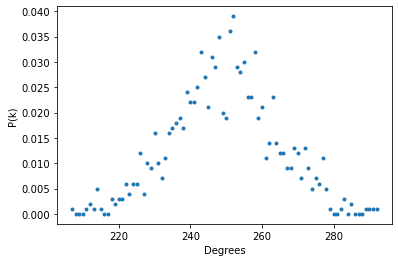

In [2]:
N = 1000
P = 0.25

G_r = nx.erdos_renyi_graph(N, P)
while min([d for n, d in G_r.degree()]) == 0:
          G_r = nx.erdos_renyi_graph(N, P)

k = np.arange(min([d for n,d in G_r.degree]), max([d for n,d in G_r.degree])+1)
p = [0]*len(k)

k_mean =sum(k)/len(k)

for i in range(len(k)):
    for n,d in G_r.degree:
        if k[i] == d:
            p[i] += 1
norm = sum(p)            

            
for i in range(len(p)):
    p[i] = p[i]/norm

print(p)  

fig, ax = plt.subplots()
ax.plot(k, p, '.', label = 'degrees distribution')
ax.set_xlabel("Degrees")
ax.set_ylabel("P(k)")  

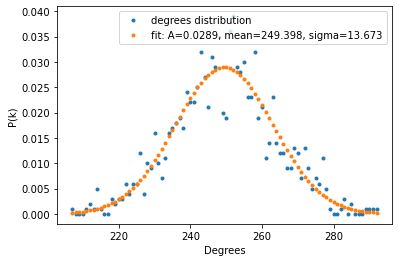

 - Data mean: 249.5
 - Mean from gaussian fit: 249.39835373366012 +/- 13.672929615200003
 - Std.dev. from poissonian fit: 13.672929615200003


Power_divergenceResult(statistic=0.11317837966647329, pvalue=1.0)

In [3]:
def gaus_law(x, a, mu=0, sigma=1):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

poptGaus, pcovGaus = curve_fit(gaus_law, k, p, 
                                         p0 = [1,k_mean, 1])

fit_function = gaus_law(k, *poptGaus)

fig, ax = plt.subplots()
ax.plot(k, p, '.', label = 'degrees distribution')
ax.set_xlabel("Degrees")
ax.set_ylabel("P(k)")      
ax.plot(k, fit_function, '.',
               label = f"fit: A={round(poptGaus[0],4)}, mean={round(poptGaus[1],3)}, sigma={round(poptGaus[2],3)}")
ax.legend()

plt.show()



print(" - Data mean:", k_mean)
print(" - Mean from gaussian fit:", poptGaus[1], '+/-', poptGaus[2])
print(" - Std.dev. from poissonian fit:", poptGaus[2])

stats.chisquare(p,fit_function)



Scale-free

In [26]:
N = [10000+i*100000 for i in range(5)]
M = 3

def power_law(x, a, b):
    return a*np.power(x, b)

G_s = nx.barabasi_albert_graph(N[0], M)

for i in range(1,len(N)):
    G_s = nx.barabasi_albert_graph(N[i], M, initial_graph = G_s)
    k = np.arange(min([d for n,d in G_s.degree]), 100)
    p_k = [0]*len(k) #vettore delle y (p(k))

    k_mean =sum(k)/len(k)
    
    

    for i in range(len(k)):
        for n,d in G_s.degree:
            if k[i] == d:
                p_k[i] += 1
    norm = sum(p) 
    

    
    for i in range(len(p_k)): #normalizzo il vettore p(k)
        p_k[i] = p_k[i]/norm
    
    fig, ax = plt.subplots()
    ax.plot(k, p_k, '.', label = 'degrees distribution')
    ax.set_xlabel("Degrees")
    ax.set_ylabel("P(k)") 
    
    # power fit
    
    poptPower, pcovPower = curve_fit(power_law, k, p_k) 
                                        
    fit_function = power_law(k, *poptPower)
    
    ax.plot(k, fit_function, '.',
               label = f"fit: a={round(poptPower[0],3)}, b={round(poptPower[1],4)}")
    ax.legend()
    plt.yscale('log')
    
    stats.chisquare(p_k, fit_function)

   

TypeError: barabasi_albert_graph() got an unexpected keyword argument 'initial_graph'